In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
import tensorflow.keras.applications.resnet50
#from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K

In [44]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [45]:
path=r"file..///users/Ketan/Desktop/GroceryStoreDataset-master/"

In [46]:
import os
train_path = '/users/Ketan/Desktop/GroceryStoreDataset-master/dataset/train' 
validation_path = '/users/Ketan/Desktop/GroceryStoreDataset-master/dataset/val' 
test_path = '/users/Ketan/Desktop/GroceryStoreDataset-master/dataset/test' 

In [47]:
from keras.preprocessing.image import ImageDataGenerator
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 10)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [48]:
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 3)


In [49]:
import PIL
print(PIL.PILLOW_VERSION)

8.2.0


<ipython-input-49-fb5b99d616c2>:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [50]:
import PIL
img_path = '/users/Ketan/Desktop/GroceryStoreDataset-master/dataset/train/Fruit/Apple/Royal-Gala/Royal-Gala_012.jpg' 
img = PIL.Image.open(img_path)

img.show()

print("Fruits: Apples")

Fruits: Apples


In [53]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [54]:
## set steps per epoch for train
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit_generator(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=steps_valid)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
52/52 [==============================] - 216s 4s/step - loss: 39.4654 - acc: 0.4571 - val_loss: 1.2795 - val_acc: 0.5101
Epoch 2/30
52/52 [==============================] - 191s 4s/step - loss: 0.7608 - acc: 0.6942 - val_loss: 1.4757 - val_acc: 0.5101
Epoch 3/30
52/52 [==============================] - 201s 4s/step - loss: 0.5211 - acc: 0.7909 - val_loss: 1.3533 - val_acc: 0.5709
Epoch 4/30
52/52 [==============================] - 210s 4s/step - loss: 0.3199 - acc: 0.8878 - val_loss: 1.3174 - val_acc: 0.5338
Epoch 5/30
52/52 [==============================] - 192s 4s/step - loss: 0.2166 - acc: 0.9253 - val_loss: 1.4905 - val_acc: 0.4865
Epoch 6/30
52/52 [==============================] - 185s 4s/step - loss: 0.1843 - acc: 0.9451 - val_loss: 4.2733 - val_acc: 0.4324
Epoch 7/30
52/52 [==============================] - 184s 3s/step - loss: 0.1581 - acc: 0.9397 - val_loss: 1.2257 - val_acc: 0.6149
Epoch 8/30
52/52 [==============================] - 510s 10s/step - loss: 0.0647 -

In [55]:
model.save('groceries_basic_model_da1')

INFO:tensorflow:Assets written to: groceries_basic_model_da1/assets


<ipython-input-57-ac82883176fa>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-57-ac82883176fa>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


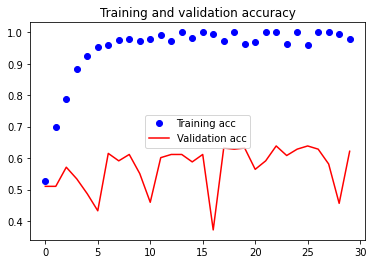

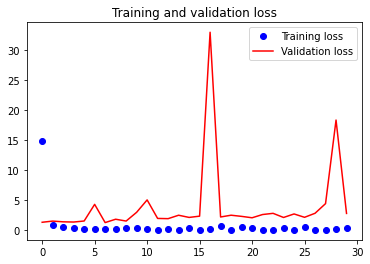

In [57]:
import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [58]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_3 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=steps_valid)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
52/52 [==============================] - 217s 4s/step - loss: 0.8234 - acc: 0.6650 - val_loss: 0.9227 - val_acc: 0.5811
Epoch 2/50
52/52 [==============================] - 220s 4s/step - loss: 0.5990 - acc: 0.7308 - val_loss: 0.8704 - val_acc: 0.5980
Epoch 3/50
52/52 [==============================] - 224s 4s/step - loss: 0.5502 - acc: 0.7560 - val_loss: 0.8294 - val_acc: 0.6723
Epoch 4/50
52/52 [==============================] - 228s 4s/step - loss: 0.4985 - acc: 0.7882 - val_loss: 0.8247 - val_acc: 0.6655
Epoch 5/50
52/52 [==============================] - 246s 5s/step - loss: 0.4814 - acc: 0.7992 - val_loss: 0.7693 - val_acc: 0.6385
Epoch 6/50
52/52 [==============================] - 258s 5s/step - loss: 0.4150 - acc: 0.8293 - val_loss: 0.8417 - val_acc: 0.6520
Epoch 7/50
52/52 [==============================] - 267s 5s/step - loss: 0.4231 - acc: 0.8335 - val_loss: 1.0568 - val_acc: 0.5980
Epoch 8/50
52/52 [==============================] - 254s 5s/step - loss: 0.3842 - a

In [59]:
model.save('groceries_basic_model_da1')

INFO:tensorflow:Assets written to: groceries_basic_model_da1/assets


<ipython-input-60-8e205449dabe>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-60-8e205449dabe>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


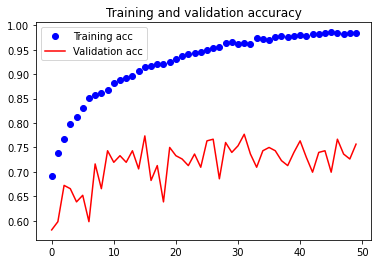

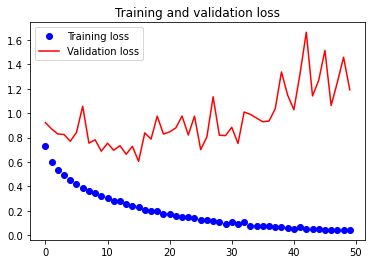

In [60]:
import matplotlib.pyplot as plt

acc = fit_generator_3.history['acc']
val_acc = fit_generator_3.history['val_acc']
loss = fit_generator_3.history['loss']
val_loss = fit_generator_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [61]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_4 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
52/52 [==============================] - 242s 5s/step - loss: 0.5480 - acc: 0.8554 - val_loss: 0.9654 - val_acc: 0.7331
Epoch 2/30
52/52 [==============================] - 223s 4s/step - loss: 0.2878 - acc: 0.8967 - val_loss: 0.7655 - val_acc: 0.7534
Epoch 3/30
52/52 [==============================] - 233s 4s/step - loss: 0.2678 - acc: 0.8951 - val_loss: 0.7826 - val_acc: 0.7432
Epoch 4/30
52/52 [==============================] - 243s 5s/step - loss: 0.2463 - acc: 0.9041 - val_loss: 0.6749 - val_acc: 0.7568
Epoch 5/30
52/52 [==============================] - 234s 4s/step - loss: 0.2548 - acc: 0.9008 - val_loss: 0.7207 - val_acc: 0.7500
Epoch 6/30
52/52 [==============================] - 230s 4s/step - loss: 0.2181 - acc: 0.9235 - val_loss: 0.8308 - val_acc: 0.7466
Epoch 7/30
52/52 [==============================] - 228s 4s/step - loss: 0.2514 - acc: 0.9029 - val_loss: 0.7524 - val_acc: 0.7703
Epoch 8/30
52/52 [==============================] - 227s 4s/step - loss: 0.2095 - a

<ipython-input-62-d94420d1a9bb>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-62-d94420d1a9bb>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


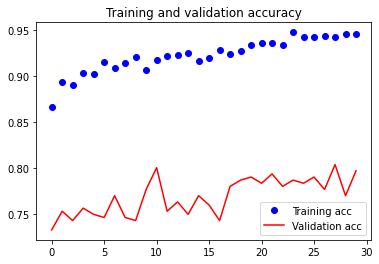

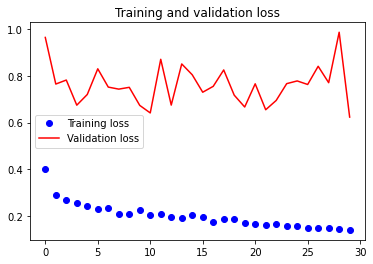

In [62]:
import matplotlib.pyplot as plt

acc = fit_generator_4.history['acc']
val_acc = fit_generator_4.history['val_acc']
loss = fit_generator_4.history['loss']
val_loss = fit_generator_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [63]:
model.save('groceries_basic_model_da2')


INFO:tensorflow:Assets written to: groceries_basic_model_da2/assets


In [64]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()
model.save('groceries_basic_model_dropout')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [65]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model2_fit_generator = model2.fit_generator(
        train_generator,
        steps_per_epoch=75,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=30)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
75/75 [==============================] - 121s 2s/step - loss: 0.9675 - acc: 0.5264 - val_loss: 0.9967 - val_acc: 0.5439
Epoch 2/50
75/75 [==============================] - 119s 2s/step - loss: 0.7550 - acc: 0.6685 - val_loss: 0.8953 - val_acc: 0.5709
Epoch 3/50
75/75 [==============================] - 113s 2s/step - loss: 0.6923 - acc: 0.6859 - val_loss: 0.8957 - val_acc: 0.5574
Epoch 4/50
75/75 [==============================] - 118s 2s/step - loss: 0.7155 - acc: 0.6697 - val_loss: 0.8861 - val_acc: 0.6250
Epoch 5/50
75/75 [==============================] - 119s 2s/step - loss: 0.6488 - acc: 0.6968 - val_loss: 0.8739 - val_acc: 0.6182
Epoch 6/50
75/75 [==============================] - 119s 2s/step - loss: 0.6694 - acc: 0.7183 - val_loss: 0.9351 - val_acc: 0.5912
Epoch 7/50
75/75 [==============================] - 122s 2s/step - loss: 0.6407 - acc: 0.7270 - val_loss: 0.8942 - val_acc: 0.5980
Epoch 8/50
75/75 [==============================] - 121s 2s/step - loss: 0.6159 - a

In [66]:
model2.save('groceries_basic_model_dropout')

INFO:tensorflow:Assets written to: groceries_basic_model_dropout/assets


<ipython-input-67-7e0423b51c8e>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-67-7e0423b51c8e>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


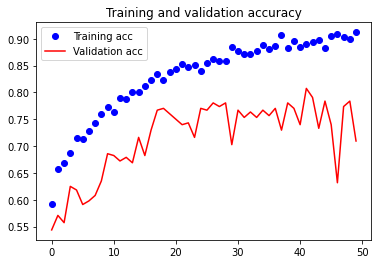

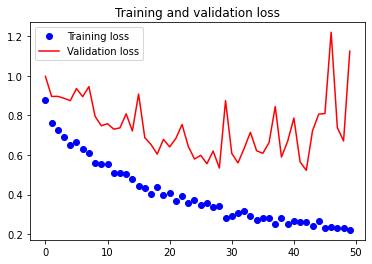

In [67]:
import matplotlib.pyplot as plt

acc = model2_fit_generator.history['acc']
val_acc = model2_fit_generator.history['val_acc']
loss = model2_fit_generator.history['loss']
val_loss = model2_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
model2_test_datagen = ImageDataGenerator(rescale=1./255)

model2_test_generator = model2_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = model2_test_generator.filenames
nb_samples = len(filenames)

model2_predict = model2.predict_generator(model2_test_generator,steps = nb_samples, verbose=2)

Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2485/2485 - 61s


Confusion matrix, without normalization
[[942 121  54]
 [  0 781   0]
 [179 117 291]]
['Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_002.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_003.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_004.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_005.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_006.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_007.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_008.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_009.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_010.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_011.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_012.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_013.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_014.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_015.jpg', 'Fruit/Apple/Golden-Delicious/Golden-Delicious_016.jpg', '

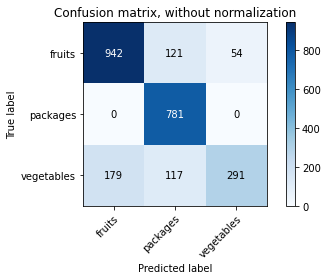

In [69]:
y_true = model2_test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

In [79]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
from tensorflow import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from keras.applications.resnet import ResNet50
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K


In [81]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')


In [82]:
vgg_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [84]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)
  
vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(512, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(3, activation='softmax'))
vgg_transfer_base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [85]:
vgg_train_datagen_do = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=50,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
105/105 [==============================] - 954s 9s/step - loss: 0.9947 - acc: 0.6217 - val_loss: 0.3964 - val_acc: 0.8142
Epoch 2/50
105/105 [==============================] - 959s 9s/step - loss: 0.4729 - acc: 0.7882 - val_loss: 0.3725 - val_acc: 0.8345
Epoch 3/50
105/105 [==============================] - 952s 9s/step - loss: 0.4254 - acc: 0.8032 - val_loss: 0.3886 - val_acc: 0.7973
Epoch 4/50
105/105 [==============================] - 878s 8s/step - loss: 0.4228 - acc: 0.7961 - val_loss: 0.3365 - val_acc: 0.8649
Epoch 5/50
105/105 [==============================] - 2745s 26s/step - loss: 0.3762 - acc: 0.8262 - val_loss: 0.3365 - val_acc: 0.8378
Epoch 6/50
105/105 [==============================] - 1030s 10s/step - loss: 0.3630 - acc: 0.8336 - val_loss: 0.4274 - val_acc: 0.7905
Epoch 7/50
105/105 [==============================] - 1082s 10s/step - loss: 0.3595 - acc: 0.8366 - val_loss: 0.4500 - val_acc: 0.7838
Epoch 8/50
105/105 [==============================] - 1066s 10s

In [88]:
vgg_transfer_base_model.save('vgg_model_dropout')

INFO:tensorflow:Assets written to: vgg_model_dropout/assets


<ipython-input-89-cc3579dec5ef>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-89-cc3579dec5ef>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


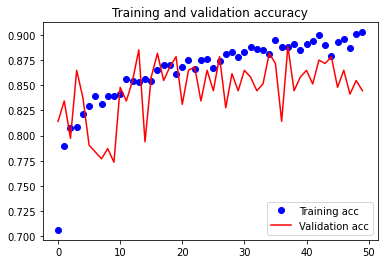

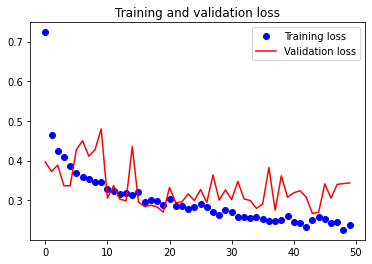

In [89]:
import matplotlib.pyplot as plt

acc = vgg_base_fit_generator_do.history['acc']
val_acc = vgg_base_fit_generator_do.history['val_acc']
loss = vgg_base_fit_generator_do.history['loss']
val_loss = vgg_base_fit_generator_do.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [90]:
vgg_test_generator_do = vgg_test_datagen_do.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_do = vgg_test_generator_do.filenames
nb_samples_do = len(filenames_do)

predict_do = vgg_transfer_base_model.predict_generator(vgg_test_generator_do,steps = nb_samples_do, verbose=2)


Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2485/2485 - 832s


Confusion matrix, without normalization
[[1068    0   49]
 [   6  771    4]
 [ 234    4  349]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

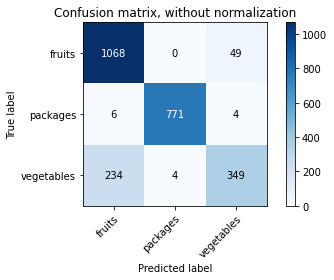

In [91]:
do_y_true = vgg_test_generator_do.classes
do_y_pred = predict_do.argmax(axis=1)
plot_confusion_matrix(do_y_true, do_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')


In [93]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model_2 = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model_2.add(layer)
  
vgg_transfer_base_model_2.layers.pop()
for layer in vgg_transfer_base_model_2.layers:
  layer.trainable=False

vgg_transfer_base_model_2.add(Dense(512, activation = 'relu'))
#vgg_transfer_base_model_2.add(Dropout(0.5))
vgg_transfer_base_model_2.add(Dense(3, activation='softmax'))
vgg_transfer_base_model_2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [94]:
## data augmentation datagen

vgg_train_datagen_nd = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
## test generator, required for prediction
vgg_test_datagen_nd = ImageDataGenerator(rescale=1./255)
## train generator
vgg_train_generator_nd = vgg_train_datagen_nd.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_nd = vgg_test_datagen_nd.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

vgg_transfer_base_model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

vgg_base_fit_generator_nd = vgg_transfer_base_model_2.fit_generator(
        vgg_train_generator_nd,
        steps_per_epoch=60,
        epochs=50,
        validation_data=vgg_validation_generator_nd,
        validation_steps=30,
        verbose=1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
60/60 [==============================] - 651s 11s/step - loss: 1.1241 - acc: 0.5975 - val_loss: 0.4299 - val_acc: 0.8176
Epoch 2/50
60/60 [==============================] - 543s 9s/step - loss: 0.5488 - acc: 0.7719 - val_loss: 0.4971 - val_acc: 0.7635
Epoch 3/50
60/60 [==============================] - 541s 9s/step - loss: 0.5061 - acc: 0.7912 - val_loss: 0.4447 - val_acc: 0.7872
Epoch 4/50
60/60 [==============================] - 541s 9s/step - loss: 0.4497 - acc: 0.7931 - val_loss: 0.3271 - val_acc: 0.8581
Epoch 5/50
60/60 [==============================] - 564s 9s/step - loss: 0.4337 - acc: 0.7985 - val_loss: 0.3248 - val_acc: 0.8514
Epoch 6/50
60/60 [==============================] - 569s 10s/step - loss: 0.4196 - acc: 0.8017 - val_loss: 0.3643 - val_acc: 0.8243
Epoch 7/50
60/60 [==============================] - 566s 9s/step - loss: 0.3833 - acc: 0.8358 - val_loss: 0.3242 - val_acc: 0.8649
Epoch 8/50
60/60 [==============================] - 581s 10s/step - loss: 0.3898 

In [95]:
vgg_transfer_base_model_2.save('vgg_model_no_dropout')

INFO:tensorflow:Assets written to: vgg_model_no_dropout/assets


<ipython-input-96-6f8deba563de>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-96-6f8deba563de>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


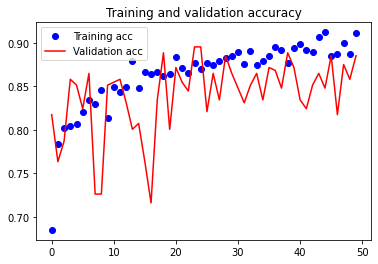

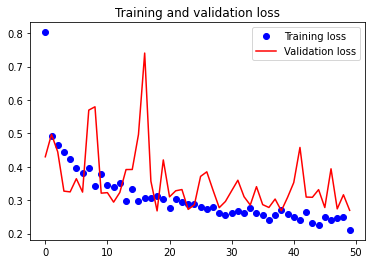

In [96]:
acc = vgg_base_fit_generator_nd.history['acc']
val_acc = vgg_base_fit_generator_nd.history['val_acc']
loss = vgg_base_fit_generator_nd.history['loss']
val_loss = vgg_base_fit_generator_nd.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [97]:
vgg_test_datagen_nd = ImageDataGenerator(rescale=1./255)

vgg_test_generator_nd = vgg_test_datagen_nd.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = vgg_test_generator_nd.filenames
nb_samples = len(filenames)

predict_nd = vgg_transfer_base_model_2.predict_generator(vgg_test_generator_nd,steps = nb_samples, verbose=2)

Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2485/2485 - 1056s


Confusion matrix, without normalization
[[971   6 140]
 [  0 780   1]
 [115   5 467]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

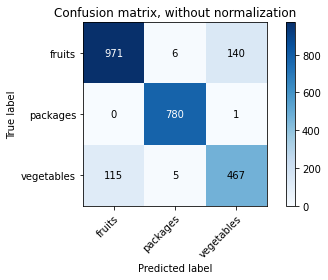

In [98]:
nd_y_true = vgg_test_generator_nd.classes
nd_y_pred = predict_nd.argmax(axis=1)
plot_confusion_matrix(nd_y_true, nd_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')


In [101]:
## data augmentation datagen
## test generator, required for prediction
## train generator
## validation generator
## compile model
## set steps per epoch for train
## set steps per epoch for validation
## fit model
vgg_train_datagen_lr5 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

vgg_test_datagen_lr5 = ImageDataGenerator(rescale=1./255)

vgg_train_generator_lr5 = vgg_train_datagen_lr5.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

vgg_validation_generator_lr5 = vgg_test_datagen_lr5.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

vgg_transfer_base_model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

vgg_base_fit_generator_lr5 = vgg_transfer_base_model_2.fit_generator(
        vgg_train_generator_lr5,
        steps_per_epoch=60,
        epochs=30,
        validation_data=vgg_validation_generator_lr5,
        validation_steps=30,
        verbose=1)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
60/60 [==============================] - 694s 12s/step - loss: 0.1964 - acc: 0.9102 - val_loss: 0.2661 - val_acc: 0.8818
Epoch 2/30
60/60 [==============================] - 746s 12s/step - loss: 0.1677 - acc: 0.9360 - val_loss: 0.2761 - val_acc: 0.8716
Epoch 3/30
60/60 [==============================] - 672s 11s/step - loss: 0.2015 - acc: 0.9210 - val_loss: 0.2788 - val_acc: 0.8682
Epoch 4/30
60/60 [==============================] - 641s 11s/step - loss: 0.1817 - acc: 0.9233 - val_loss: 0.2704 - val_acc: 0.8986
Epoch 5/30
60/60 [==============================] - 627s 10s/step - loss: 0.1568 - acc: 0.9402 - val_loss: 0.2849 - val_acc: 0.8716
Epoch 6/30
60/60 [==============================] - 626s 10s/step - loss: 0.1856 - acc: 0.9238 - val_loss: 0.2664 - val_acc: 0.8885
Epoch 7/30
60/60 [==============================] - 636s 11s/step - loss: 0.1868 - acc: 0.9196 - val_loss: 0.2853 - val_acc: 0.8682
Epoch 8/30
60/60 [==============================] - 585s 10s/step - loss: 0.

<ipython-input-102-a7d605af037d>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-102-a7d605af037d>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


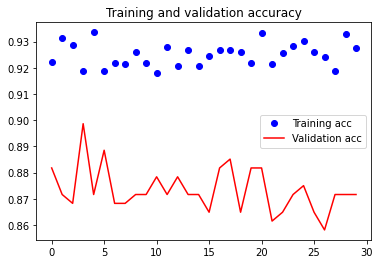

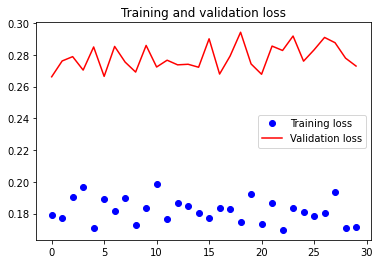

In [102]:
acc = vgg_base_fit_generator_lr5.history['acc']
val_acc = vgg_base_fit_generator_lr5.history['val_acc']
loss = vgg_base_fit_generator_lr5.history['loss']
val_loss = vgg_base_fit_generator_lr5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [103]:
vgg_test_datagen_lr5 = ImageDataGenerator(rescale=1./255)

vgg_test_generator_lr5 = vgg_test_datagen_lr5.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_lr5 = vgg_test_generator_lr5.filenames
nb_samples_lr5 = len(filenames_lr5)

predict_lr5 = vgg_transfer_base_model_2.predict_generator(vgg_test_generator_lr5,steps = nb_samples_lr5, verbose=2)


Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2485/2485 - 815s


Confusion matrix, without normalization
[[1010    2  105]
 [   0  778    3]
 [ 150    5  432]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

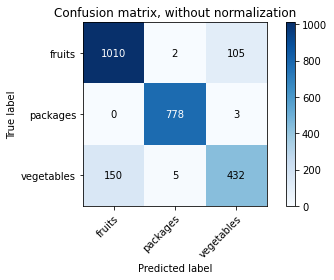

In [104]:
lr5_y_true = vgg_test_generator_lr5.classes
lr5_y_pred = predict_lr5.argmax(axis=1)
plot_confusion_matrix(lr5_y_true, lr5_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')

In [105]:
from keras.applications.resnet50 import ResNet50

resnet50_base_model = ResNet50(weights='imagenet', include_top=False)
#resnet50_trainable_model = ResNet50(weights=None, include_top=False)

94773248/94765736 [==============================] - 49s 1us/step


In [106]:
resnet50_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [109]:
## building base model with frozen weights

base_x = resnet50_base_model.output
global_pooling_x = GlobalAveragePooling2D()(base_x)
#add dense layer
dense_layer = Dense(512, activation='relu')(global_pooling_x)
#add final output layer
base_prediction = Dense(3, activation = 'softmax')(dense_layer)

#create the whole network
resnet_transfer_model_1 = Model(inputs=resnet50_base_model.input, outputs=base_prediction)

#resnet_transfer_model_1.summary()

In [110]:
resnet_transfer_model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [111]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

res_train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

res_test_datagen = ImageDataGenerator(rescale=1./255)

res_train_generator = res_train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

res_validation_generator = res_test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames_res = res_train_generator.filenames
steps_train_res = len(train_filenames_res)/res_train_generator.batch_size

## set steps per epoch for validation
validation_filenames_res = res_validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/res_validation_generator.batch_size


print(len(validation_filenames_res), " ", steps_valid_res)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
296   29.6


In [112]:
resnet_transfer_model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

resnet_model_1_fit_generator = resnet_transfer_model_1.fit_generator(
        res_train_generator,
        steps_per_epoch=steps_train_res,
        epochs=30,
        validation_data=res_validation_generator,
        validation_steps=steps_valid_res)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
132/132 [==============================] - 1275s 10s/step - loss: 0.2927 - acc: 0.8804 - val_loss: 5.9335 - val_acc: 0.3750
Epoch 2/30
132/132 [==============================] - 2486s 19s/step - loss: 0.0598 - acc: 0.9843 - val_loss: 1.5357 - val_acc: 0.3311
Epoch 3/30
132/132 [==============================] - 1268s 10s/step - loss: 0.0403 - acc: 0.9888 - val_loss: 7.6808 - val_acc: 0.3750
Epoch 4/30
132/132 [==============================] - 1336s 10s/step - loss: 0.0654 - acc: 0.9814 - val_loss: 26.7571 - val_acc: 0.3378
Epoch 5/30
132/132 [==============================] - 1330s 10s/step - loss: 0.0234 - acc: 0.9927 - val_loss: 1.0224 - val_acc: 0.4966
Epoch 6/30
132/132 [==============================] - 1306s 10s/step - loss: 0.0414 - acc: 0.9899 - val_loss: 3.8774 - val_acc: 0.6081
Epoch 7/30
132/132 [==============================] - 1271s 10s/step - loss: 0.0137 - acc: 0.9949 - val_loss: 1.5900 - val_acc: 0.8311
Epoch 8/30
132/132 [==============================] - 

In [113]:
resnet_transfer_model_1.save('resnet50_frozen_model')

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: resnet50_frozen_model/assets


<ipython-input-114-fdfec5b18c02>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-114-fdfec5b18c02>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


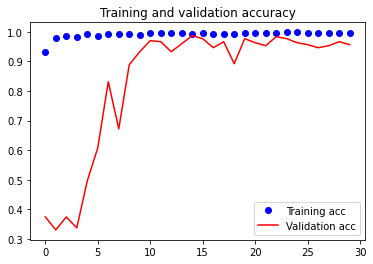

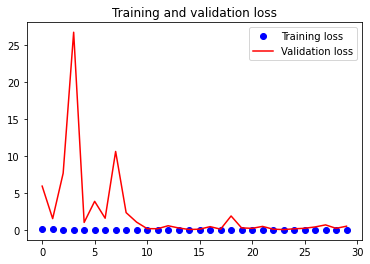

In [114]:
import matplotlib.pyplot as plt

acc = resnet_model_1_fit_generator.history['acc']
val_acc = resnet_model_1_fit_generator.history['val_acc']
loss = resnet_model_1_fit_generator.history['loss']
val_loss = resnet_model_1_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [115]:
resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_test_generator.filenames
nb_samples = len(filenames)
#nb_samples


predict = resnet_transfer_model_1.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)

Found 2485 images belonging to 3 classes.


/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2485/2485 - 379s


Confusion matrix, without normalization
[[1079   29    9]
 [   0  781    0]
 [  46    6  535]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

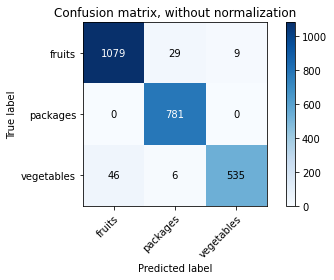

In [116]:
r_y_true = resnet_test_generator.classes
r_y_pred = predict.argmax(axis=1)
plot_confusion_matrix(r_y_true, r_y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')


In [119]:
model.save('grocery')

INFO:tensorflow:Assets written to: grocery/assets
